**Описание проекта**

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.
«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования. У компании есть небольшой отдел цифровых технологий, и вам предстоит побыть в роли стажёра в этом отделе. 
Итак, вашему отделу поручили разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Как решать задачу?**

1.Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.

2.В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.

3.Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.

In [ ]:
#импорты 
!pip install shap
!pip install matplotlib
!pip install --upgrade shap matplotlib seaborn -q
!pip install phik
!pip install --upgrade scikit-learn


import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from statsmodels.stats.outliers_influence import variance_inflation_factor


from phik import phik_matrix
from phik.report import plot_correlation_matrix


  Using cached numpy-1.24.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2


**Шаг 1. Загрузка данных** 

In [2]:
# Загрузка файлов с указанием разделителя и десятичного знака
market_file = pd.read_csv('train_job_satisfaction_rate.csv', delimiter=',')
market_money = pd.read_csv('/datasets/market_money.csv', delimiter=',')
market_time = pd.read_csv('/datasets/market_time.csv', delimiter=',')
money = pd.read_csv('/datasets/money.csv', delimiter=';', decimal=',')

In [3]:
# Выводим первые 5 строк таблицы market_file
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [4]:
# Выводим первые 5 строк таблицы market_money
market_money.head()

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.0
1,215348,текущий_месяц,3293.1
2,215348,предыдущий_месяц,0.0
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6


In [5]:
# Выводим первые 5 строк таблицы market_time

market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [6]:
# Выводим первые 5 строк таблицы money
money.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


**Шаг 2. Предобработка данных**

Работаем с таблицей *market_file*

In [7]:
# Выведем информацию о данных
market_file.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [8]:
# Проверяем на наличие пропусков 
market_file.isna().sum()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

In [9]:
# Исправляем опечатки 

market_file['Тип сервиса'] = market_file['Тип сервиса'].str.replace('стандартт', 'стандарт')
market_file['Популярная_категория'] = market_file['Популярная_категория'].str.replace('аксесуары', 'аксессуары')
market_file.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2


In [10]:
# Выведем на экран количество строк-дубликатов в market_file

market_file.duplicated().sum()

# Дубликатов не обнаружено

0

Работаем с таблицей *market_money*

In [11]:
# Выведем информацию о данных
market_money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [12]:
# Выведем на экран количество строк-дубликатов в market_money

market_money.duplicated().sum()

# Дубликатов не обнаружено

0

Работаем с таблицей *market_time*

In [13]:
# Выведем информацию о данных
market_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [14]:
# Проверяем на наличие пропусков 
market_time.isna().sum()

id        0
Период    0
минут     0
dtype: int64

In [15]:
value_counts = market_time['Период'].value_counts()
print(value_counts)

текущий_месяц       1300
предыдцщий_месяц    1300
Name: Период, dtype: int64


In [16]:
# Исправляем опечатки 

market_time['Период'] = market_time['Период'].str.replace('предыдцщий_месяц', 'предыдущий_месяц')
market_time.head()

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдущий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдущий_месяц,12
4,215350,текущий_месяц,13


In [17]:
# Выведем на экран количество строк-дубликатов в market_file

market_time.duplicated().sum()

# Дубликатов не обнаружено

0

Работаем с таблицей *money*

In [18]:
# Выведем информацию о данных
money.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [19]:
# Проверяем на наличие пропусков 
money.isna().sum()

id         0
Прибыль    0
dtype: int64

In [20]:
# Выведем на экран количество строк-дубликатов в market_file

money.duplicated().sum()

# Дубликатов не обнаружено

0

**Шаг 3. Исследовательский анализ данных**

Проведите исследовательский анализ данных из каждой таблицы. Отберите клиентов с покупательской активностью не менее трёх месяцев, то есть таких, которые что-либо покупали в этот период. Оформите выводы по результатам шага.

In [21]:
# Отбор клиентов, которые имели выручку за все три месяца
market_money_active = market_money[market_money['Выручка'] > 0]
market_money_active.head()

,id,Период,Выручка
1,215348,текущий_месяц,3293.1
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0


In [22]:
# Фильтруем строки с выручкой больше 0
market_money_active = market_money[market_money['Выручка'] > 0]

# Группируем по 'id' и оставляем только уникальные активные 'id'
active_ids = market_money_active['id'].unique()

# Фильтруем оригинальный DataFrame по активным id, у которых нет нулевой выручки
market_money_active_users = market_money.groupby('id').filter(lambda x: (x['Выручка'] > 0).all())

# Выводим DataFrame только с активными пользователями
print("DataFrame активных пользователей:")
print(market_money_active_users)

DataFrame активных пользователей:
          id               Период  Выручка
3     215349  препредыдущий_месяц   4472.0
4     215349        текущий_месяц   4971.6
5     215349     предыдущий_месяц   5216.0
6     215350  препредыдущий_месяц   4826.0
7     215350        текущий_месяц   5058.4
...      ...                  ...      ...
3895  216646  препредыдущий_месяц   4725.0
3896  216646     предыдущий_месяц   4923.0
3897  216647     предыдущий_месяц   4720.0
3898  216647  препредыдущий_месяц   5183.0
3899  216647        текущий_месяц   4448.3

[3891 rows x 3 columns]


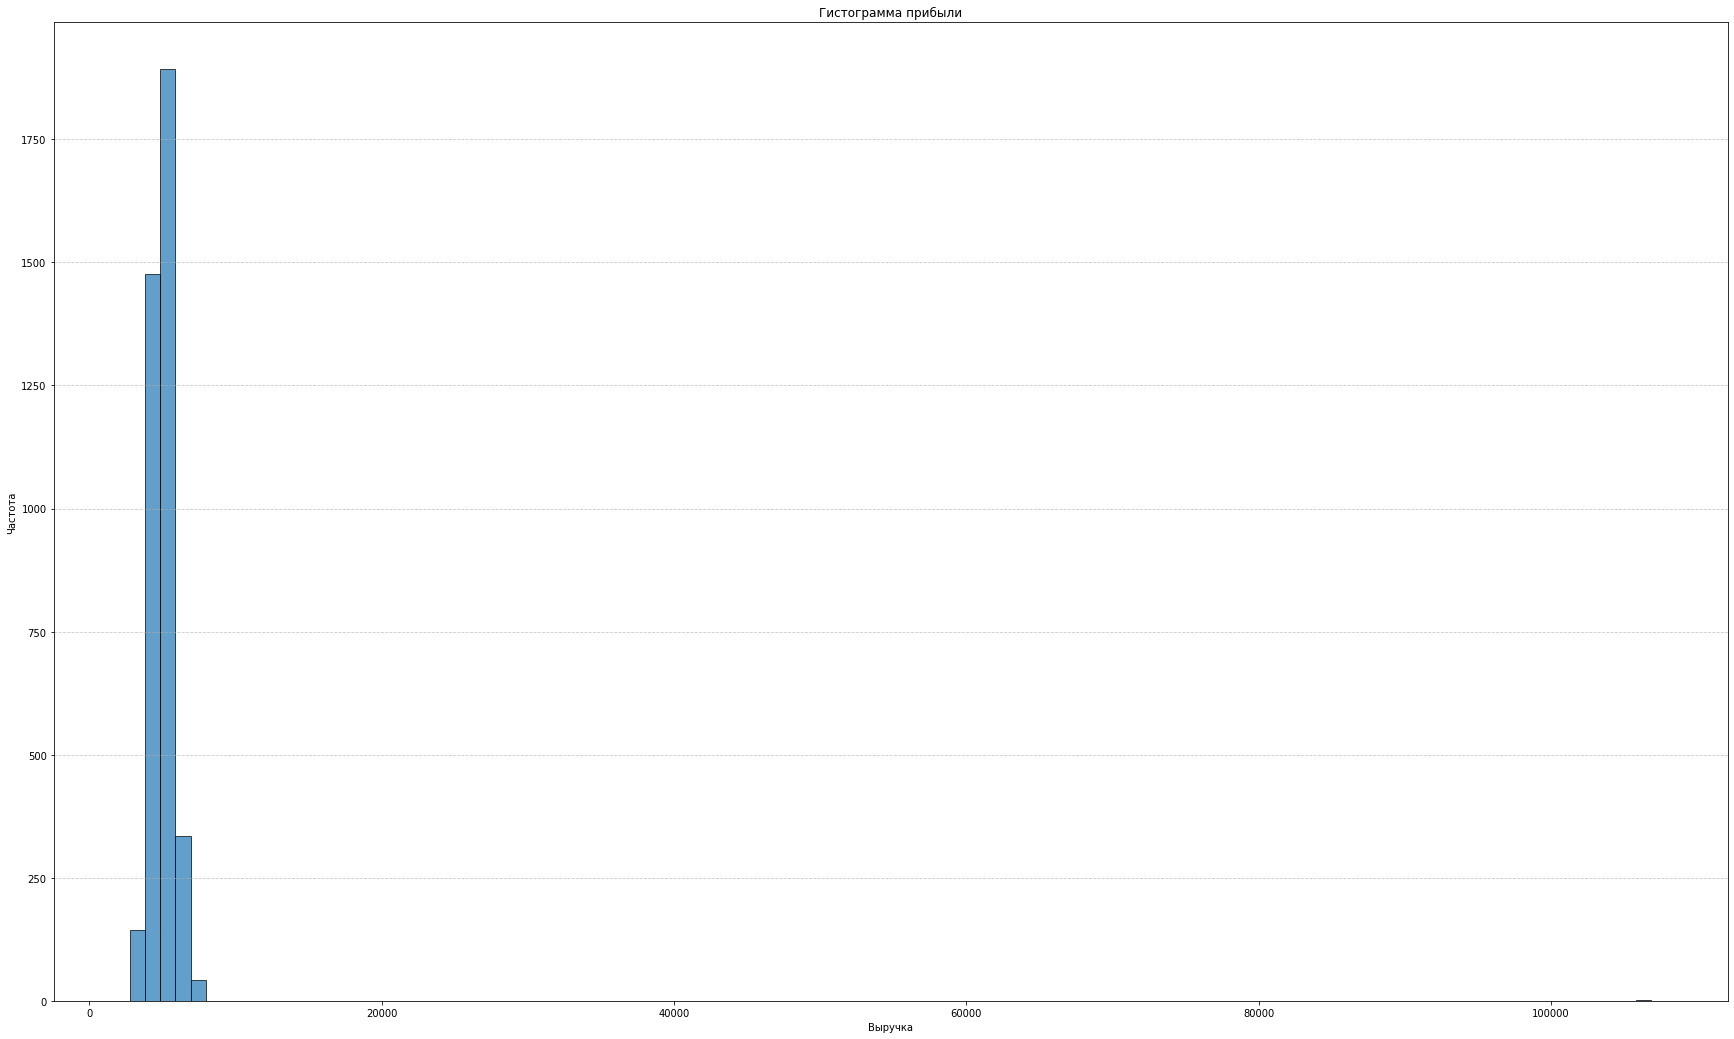

In [23]:
#ищем аномальные значения
# Построение гистограммы для столбца 'выручка'
plt.figure(figsize=(30, 18))
plt.hist(market_money_active_users['Выручка'], bins=100, edgecolor='black', alpha=0.7)
plt.title('Гистограмма прибыли')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

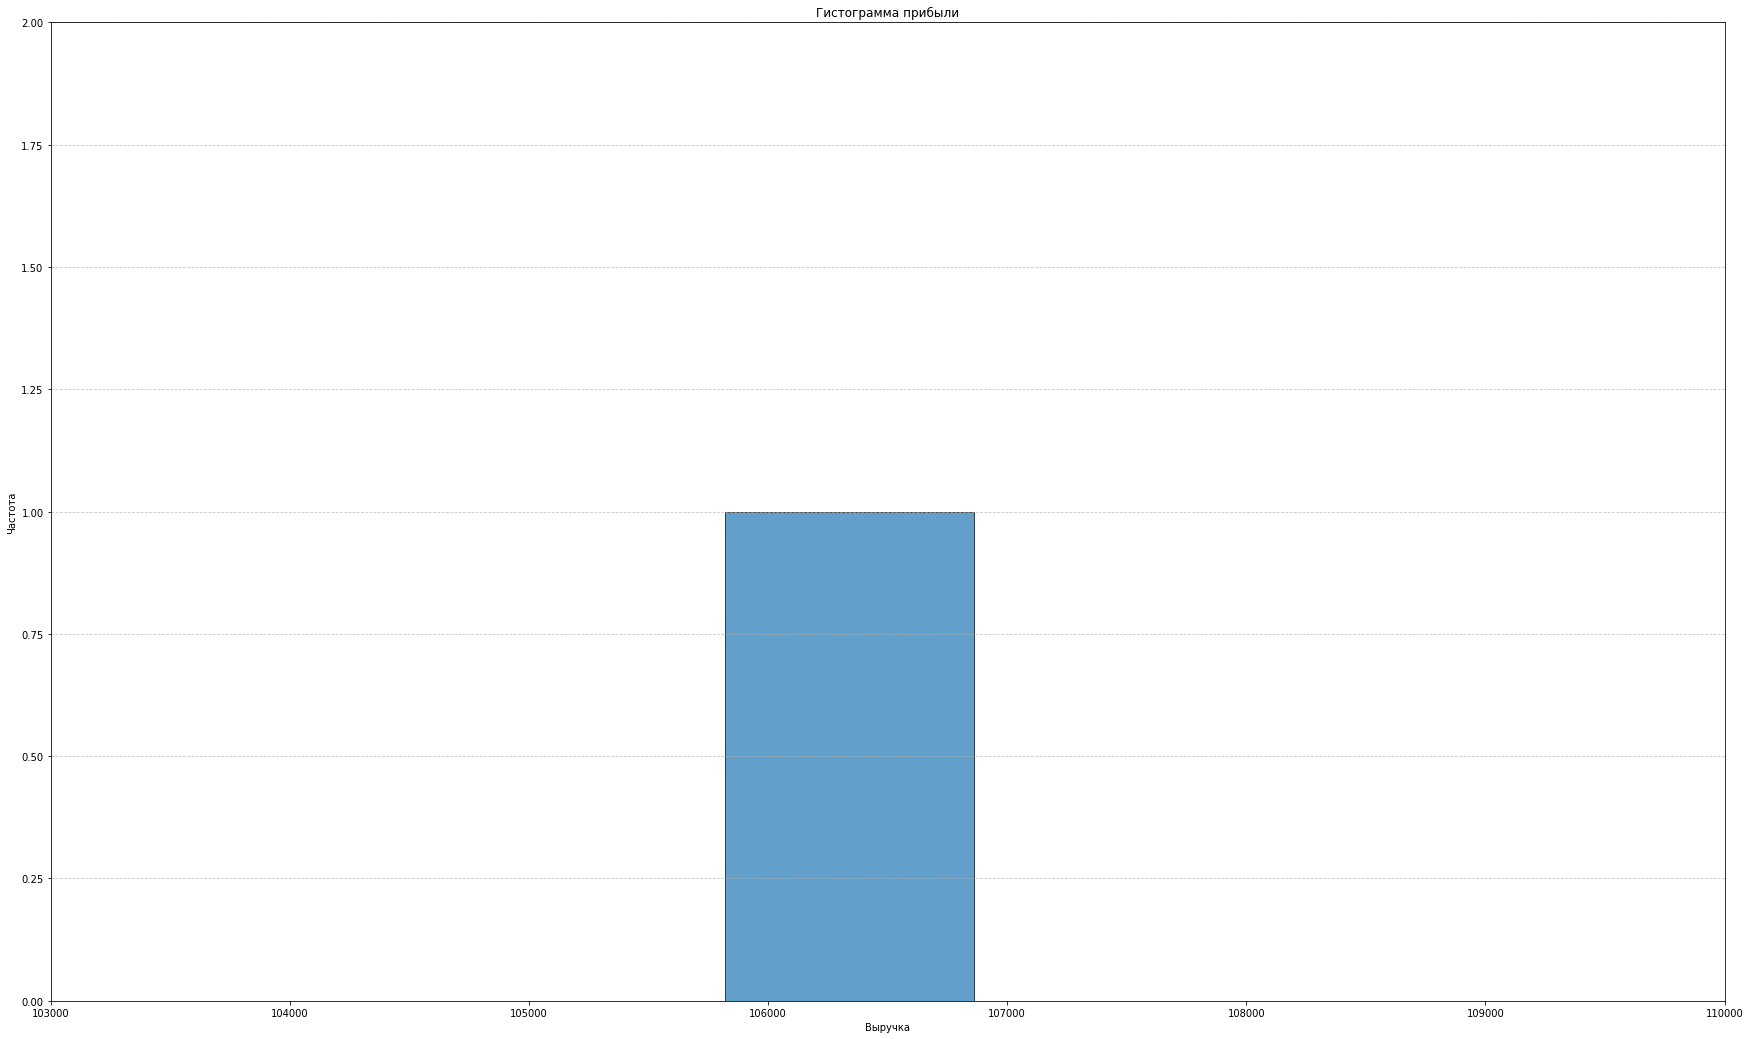

In [24]:
# Для более подброного изучения аномалии рассмотрим график на диапазоне от 103 000 до 110 000

# Построение гистограммы с акцентом на интересующем диапазоне
plt.figure(figsize=(30, 18))
plt.hist(market_money_active_users['Выручка'], bins=100, edgecolor='black', alpha=0.7)
plt.title('Гистограмма прибыли')
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.xlim(103000, 110000)  # Устанавливаем пределы для оси X
plt.ylim(0, 2)  # Устанавливаем пределы для оси y
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
filtered_data = market_money_active_users[(market_money_active_users['Выручка'] >= 105000) & 
                                          (market_money_active_users['Выручка'] <= 107000)]

# Вывод отфильтрованных данных
filtered_data

,id,Период,Выручка
98,215380,текущий_месяц,106862.2


In [26]:
# удаляем аномальные значения из датасета 
market_money_active_users = market_money_active_users[(market_money_active_users['Выручка'] < 105000)]
market_money_active_users

,id,Период,Выручка
3,215349,препредыдущий_месяц,4472.0
4,215349,текущий_месяц,4971.6
5,215349,предыдущий_месяц,5216.0
6,215350,препредыдущий_месяц,4826.0
7,215350,текущий_месяц,5058.4
...,...,...,...
3895,216646,препредыдущий_месяц,4725.0
3896,216646,предыдущий_месяц,4923.0
3897,216647,предыдущий_месяц,4720.0
3898,216647,препредыдущий_месяц,5183.0


In [27]:
# Отбор клиентов, которые имели прибыль за все три месяца
money_active = money[money['Прибыль'] > 0]
money_active.head()

,id,Прибыль
0,215348,0.98
1,215349,4.16
2,215350,3.13
3,215351,4.87
4,215352,4.21


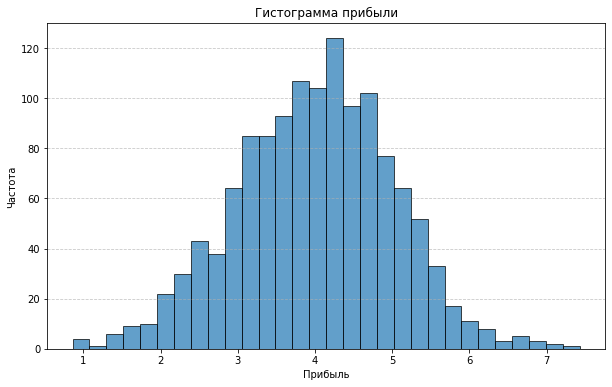

In [28]:
# Построение гистограммы для столбца 'Прибыль'
plt.figure(figsize=(10, 6))
plt.hist(money['Прибыль'], bins=30, edgecolor='black', alpha=0.7)
plt.title('Гистограмма прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Шаг 4. Объединение таблиц**


In [29]:
# Обработка данных о выручке
revenue_pivot = market_money.pivot(index='id', columns='Период', values='Выручка')
revenue_pivot.columns = ['{}_выручка'.format(col) for col in revenue_pivot.columns]

# Обработка данных о времени на сайте
time_pivot = market_time.pivot(index='id', columns='Период', values='минут')
time_pivot.columns = ['{}_время'.format(col) for col in time_pivot.columns]

# Объединение таблиц
merged_df = market_file.merge(revenue_pivot, on='id', how='left')
merged_df = merged_df.merge(time_pivot, on='id', how='left')
merged_df = merged_df.merge(money, on='id', how='left')

# Сохранение итоговой таблицы в новый CSV файл
merged_df.to_csv('merged_market_data.csv', index=False)
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,Прибыль
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21


**Шаг 5. Корреляционный анализ**

Проведите корреляционный анализ признаков в количественной шкале в итоговой таблице для моделирования. Сделайте выводы о мультиколлинеарности и при необходимости устраните её.

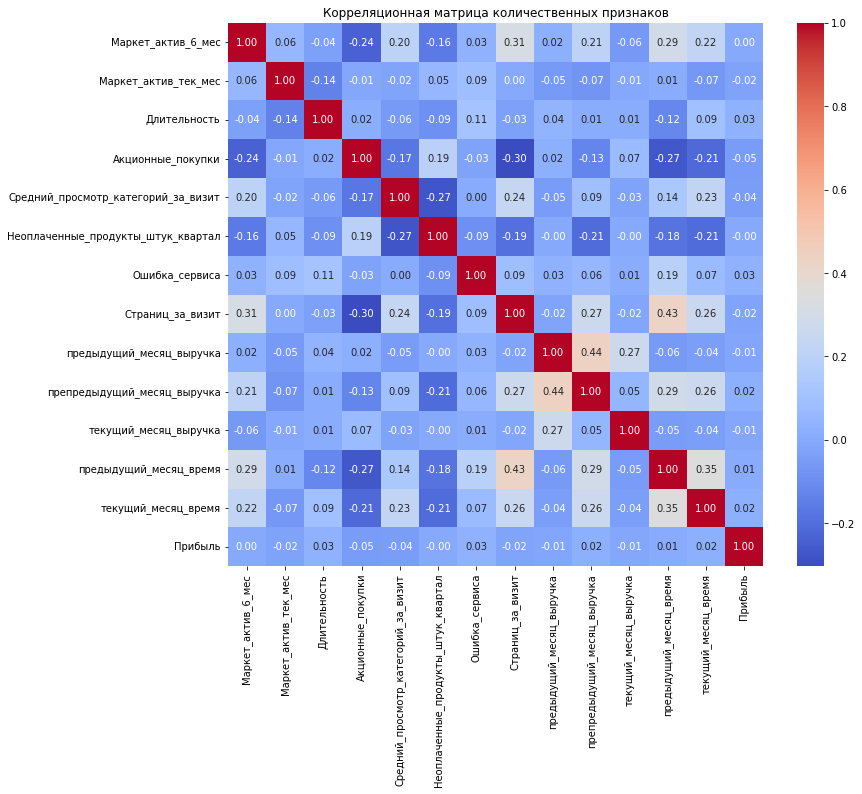

In [30]:
# Выбираем только количественные признаки для анализа
# Исключаем ID, категориальные и целевые переменные
quantitative_features = merged_df.select_dtypes(include=['float64', 'int64']).drop(columns=['id'])

# Вычисление корреляционной матрицы
corr_matrix = quantitative_features.corr()

# Визуализация корреляционной матрицы
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Корреляционная матрица количественных признаков")
plt.show()

In [31]:
# создаём список с наименованиями непрерывных признаков
interval_cols = ['маркет_актив_6_мес', 'Длительность', 'Акционные_покупки', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка']

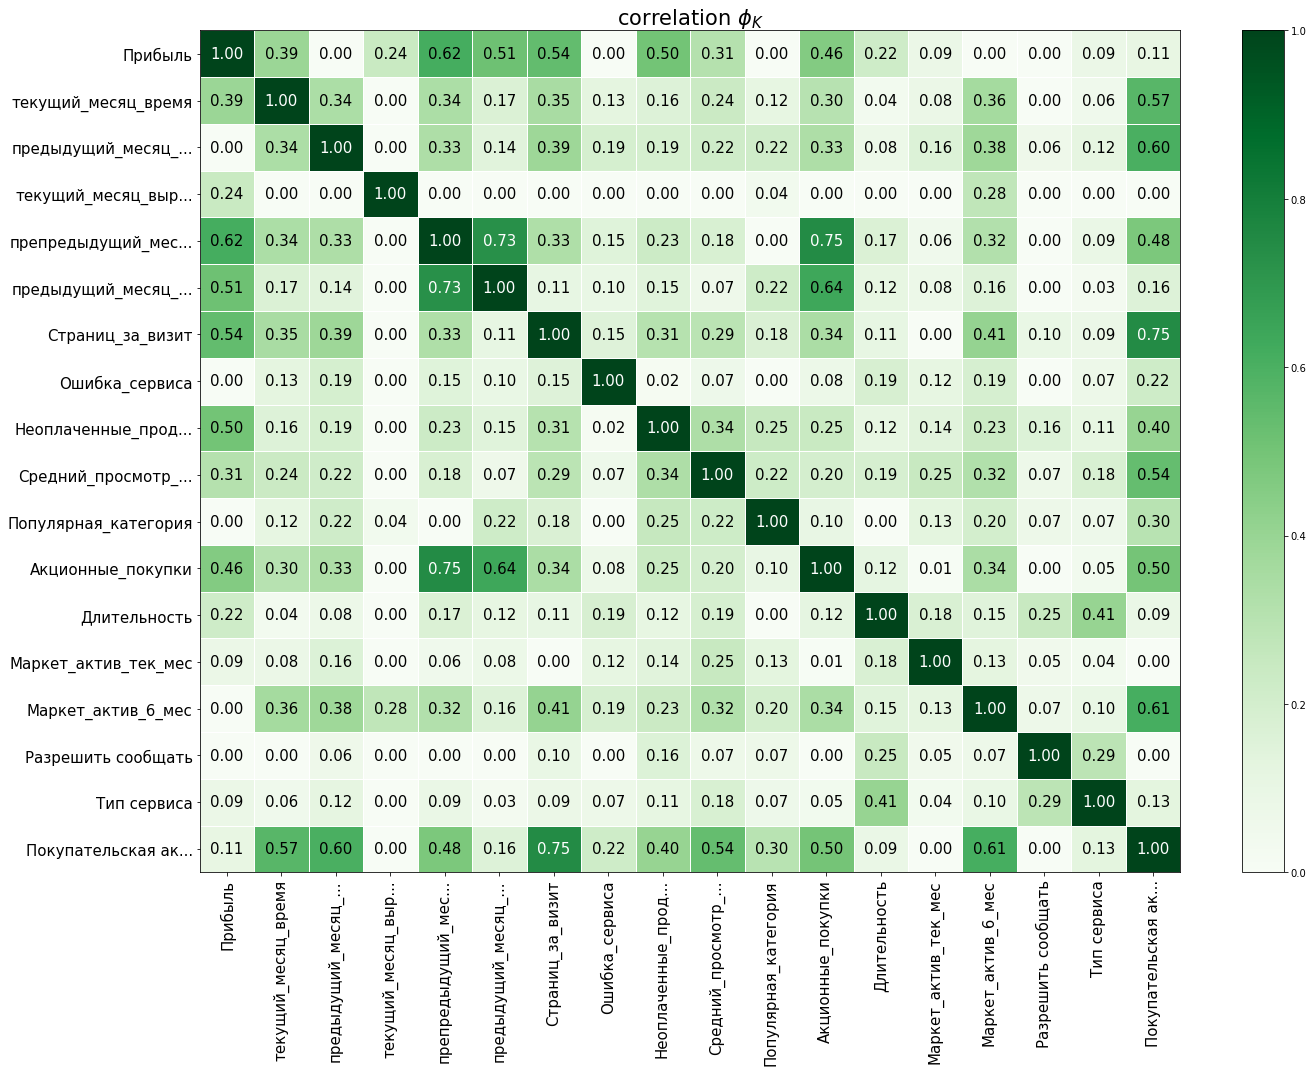

In [32]:
# Удаляем столбец 'id' из DataFrame
data_without_id = merged_df.drop(columns=['id'])
    
# Рассчитываем матрицу корреляции методом, подходящим для ваших данных
phik_overview = data_without_id.phik_matrix(interval_cols=interval_cols)
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    vmin=0, vmax=1, color_map='Greens',
    title=r'correlation $\phi_K$',
    fontsize_factor=1.5,
    figsize=(20, 15)
)

У целевого признака "покупательская активность" нет корреляции, равной "1" с другими признаками. Но отмечается высокая зависимость (более 70%) от: акционных покупок и страниц за визит

In [33]:
# Анализ мультиколлинеарности с использованием VIF
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["Feature"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

vif_data = calculate_vif(quantitative_features)
print(vif_data)

# Устранение мультиколлинеарности: 

if vif_data['VIF'].max() > 10:  # Обычный порог для высокого VIF
    feature_to_remove = vif_data.sort_values('VIF', ascending=False).iloc[0]['Feature']
    print(f"Удаление признака {feature_to_remove} из-за высокой мультиколлинеарности")
    quantitative_features = quantitative_features.drop(columns=[feature_to_remove])

# Повторный расчет VIF если необходимо

                                Feature         VIF
0                    Маркет_актив_6_мес   22.205972
1                  Маркет_актив_тек_мес   29.202192
2                          Длительность    7.092757
3                     Акционные_покупки    3.030708
4   Средний_просмотр_категорий_за_визит    7.754017
5    Неоплаченные_продукты_штук_квартал    3.374179
6                        Ошибка_сервиса    6.014879
7                      Страниц_за_визит    7.284817
8              предыдущий_месяц_выручка   65.367636
9           препредыдущий_месяц_выручка  144.001383
10                текущий_месяц_выручка    4.657482
11               предыдущий_месяц_время   19.098762
12                  текущий_месяц_время   13.933353
13                              Прибыль   15.649636
Удаление признака препредыдущий_месяц_выручка из-за высокой мультиколлинеарности


**Шаг 6. Использование пайплайнов**

В этом шаге мы создадим пайплайны для обработки количественных и категориальных признаков отдельно. Для категориальных признаков мы используем, например, OneHotEncoder и OrdinalEncoder. Для количественных признаков – StandardScaler и MinMaxScaler.


In [34]:
# Константы
RANDOM_STATE = 42
TEST_SIZE = 0.25

# Делим на тренировочную и тестовую выборки и удаляем целевой признак из датасета
X_train, X_test, y_train, y_test = train_test_split(
    merged_df.drop(['Покупательская активность', 'id'], axis=1),
    merged_df['Покупательская активность'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=merged_df['Покупательская активность']
)

In [35]:
# Инициализация LabelEncoder
label_encoder = LabelEncoder()

# Кодирование целевого признака в тренировочной выборке
y_train_encoded = label_encoder.fit_transform(y_train)

# Кодирование целевого признака в тестовой выборке
y_test_encoded = label_encoder.transform(y_test)

# OPTIONAL: Для понимания можно вывести маппинг
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Mapping классов:", class_mapping)

# Теперь целевой признак закодирован в числовой формат
print("Sample из y_train_encoded:", y_train_encoded[:5])
print("Sample из y_test_encoded:", y_test_encoded[:5])

Mapping классов: {'Прежний уровень': 0, 'Снизилась': 1}
Sample из y_train_encoded: [1 0 0 1 0]
Sample из y_test_encoded: [0 1 0 1 1]


In [36]:
X_train.shape, X_test.shape

# создаём списки с названиями признаков
ohe_columns = ['Популярная_категория']
ord_columns = ['Разрешить сообщать', 'Тип сервиса']

In [37]:
num_columns = [
    'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность',
    'Акционные_покупки', 'Средний_просмотр_категорий_за_визит',
    'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса',
    'Страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка',
    'текущий_месяц_выручка', 'предыдущий_месяц_время', 'текущий_месяц_время'
]

# создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
    )
    ]
)

In [38]:
# создаём пайплайн для подготовки признаков из списка ord_columns: заполнение пропусков и Ordinal-кодирование
ord_pipe = Pipeline([
    ('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),    
    ('ord', OrdinalEncoder(categories=[
        ['да', 'нет'],  # Категории для столбца "Разрешить сообщать"
        ['стандарт', 'премиум']  # Категории для столбца "Тип сервиса"
    ], handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [39]:
# создаём общий пайплайн для подготовки данных
preprocessor = ColumnTransformer([
    ('ohe', ohe_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', MinMaxScaler(), num_columns)
], remainder='passthrough')

# создайте итоговый пайплайн: подготовка данных и модель
pipe_final = Pipeline([
    ('preprocessor', preprocessor),
    ('models', DecisionTreeClassifier(random_state=42))
])

In [40]:
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 5),
        'models__max_features': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    # словарь для модели SVC()
    {
        'models': [SVC(random_state=RANDOM_STATE, probability=True)],  # Установка probability=True
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough'] 

    },    
    # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE, 
            solver='liblinear', 
            penalty='l1'
        )],
        'models__C': range(1, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
]

In [41]:
# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_final,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    error_score='raise'
)

# Обучение модели с помощью GridSearch
try:
    grid_search.fit(X_train, y_train_encoded)
    
    # Вывод результатов
    print('**Лучшая модель и её параметры:**\n\n', grid_search.best_estimator_)
    print('**Метрика лучшей модели (ROC AUC) на тренировочной выборке:**', grid_search.best_score_)
    
    # Проверка работы модели на тестовой выборке и прогноз
    y_test_pred = grid_search.predict_proba(X_test)[:, 1]
    print(f'**Метрика ROC-AUC на тестовой выборке:** {roc_auc_score(y_test_encoded, y_test_pred)}')
    
except ValueError as e:
    print(e)

**Лучшая модель и её параметры:**

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Популярная_категория']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
       

Здесь roc_auc выбирается в качестве метрики для оптимизации. Эта метрика хорошо подходит для задач бинарной классификации, поскольку она учитывает как истинные положительные, так и ложные положительные результаты. Также она устойчива к несбалансированным классам, так как оценивает качество модели по площади под кривой ROC.

In [42]:
best_model = grid_search.best_estimator_

In [43]:
# Посмотрим на имена шагов пайплайна
best_model.named_steps.keys()

dict_keys(['preprocessor', 'models'])

In [44]:
# Используйте обученную модель для объяснений
explainer = shap.KernelExplainer(
    best_model.named_steps['models'].predict,  # Используйте predict_proba для вероятностных оценок
    best_model.named_steps['preprocessor'].transform(X_train)  # Трансформированные обучающие данные
)

# Получаем SHAP значения для тестовой выборки
shap_values = explainer.shap_values(best_model.named_steps['preprocessor'].transform(X_test), nsamples=100)

Using 975 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/325 [00:00<?, ?it/s]

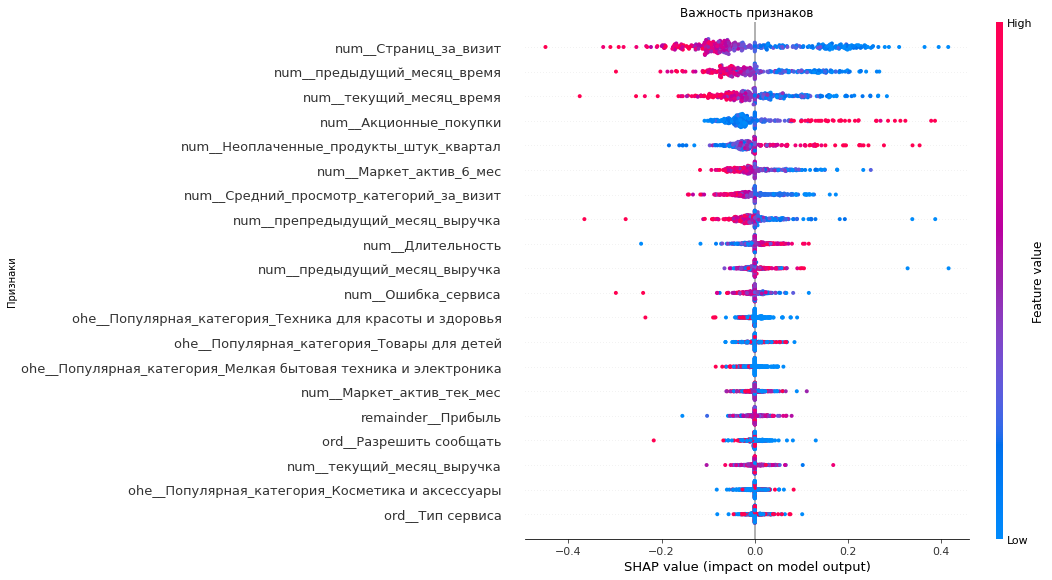

In [45]:
# Создаем график
shap.summary_plot(
    shap_values, 
    best_model.named_steps['preprocessor'].transform(X_test), 
    feature_names=best_model.named_steps['preprocessor'].get_feature_names_out(),
    plot_size=(15, 8),
    show=False
)
plt.title('Важность признаков')
plt.ylabel('Признаки')
plt.show()

**Шаг 7. Анализ важности признаков**

Оцените важность признаков для лучшей модели и постройте график важности с помощью метода SHAP

#### Признаки с низкой значимостью
Для анализа признаков на графике SHAP рассмотрим основные аспекты каждого признака:

1. **num_Страницы_за_визит**:
   - Этот признак имеет как отрицательное, так и положительное влияние на модель, причём высокие значения (красные точки) чаще способствуют увеличению предсказания модели.

2. **num_предыдущий_месяц_время**:
   - Высокие значения этого признака (красные точки) имеют смешанное влияние, но в основном способствуют увеличению предсказанного значения.

3. **num_Текущий_месяц_время**:
   - Этот признак также имеет смешанное влияние. Высокие значения в основном способствуют увеличению предсказания.

4. **num_Акционные_покупки**:
   - Высокие значения этого признака (красные точки) способствуют увеличению предсказания модели.

5. **num_Неоплаченные_продукты_штук_квартал**:
   - Признак имеет распределенное влияние, с акцентом на положительное влияние при высоких значениях.

6. **num_Маркет_актив_6_мес**:
   - Высокие значения данного признака способствуют увеличению вероятности соответствующего предсказания модели.

7. **num_Средний_просмотр_категорий_за_визит**:
   - Высокие значения признака в основном оказывают положительное влияние.

8. **num_перепредыдущий_месяц_выручка**:
   - Высокие значения имеют тенденцию к увеличению предсказания.

9. **num_Длительность**:
   - Высокие значения этого признака способствуют как увеличению, так и уменьшению предсказанного значения, но в основном увеличению.

10. **num_предыдущий_месяц_выручка**:
    - Высокие значения этого признака в основном имеют положительное влияние.

11. **num_Ошибка_сервиса**:
    - Высокие значения этого признака оказывают отрицательное влияние на предсказание модели.

12. **ohe_Популярная_категория_Техника для красоты и здоровья**:
    - Наличие этого признака (значение 1) в основном способствует уменьшению предсказанного значения.

13. **ohe_Популярная_категория_Косметика и аксессуары**:
    - Наличие этого признака в основном увеличивает предсказанное значение.

14. **num_Маркет_актив_тек_мес**:
    - Высокие значения чаще способствуют увеличению предсказанного значения.

15. **ord_Разрешить сообщать**:
    - Высокие значения признака имеют разнообразное влияние, но в основном положительное.

16. **reminder_Прибыль**:
    - Зависимость положительная: чем выше прибыль, тем выше предсказанное значение.

17. **ohe_Популярная_категория_Мелкая бытовая техника и электроника**:
    - Наличие этого признака большей частью увеличивает предсказание модели.

18. **ohe_Популярная_категория_Товары для детей**:
    - Наличие этого признака уменьшает предсказанное значение.

19. **ohe_Популярная_категория_Кухонная посуда**:
    - Наличие этого признака в основном имеет положительное влияние.

20. **ord_Тип сервиса**:
    - Этот признак имеет некоторую вариативность, но обладает в основном положительным влиянием на предсказание модели.


#### Применение наблюдений при моделировании и принятии бизнес-решений
1. Оптимизация модели:
    - Удаление мало значимых признаков может упростить модель, ускорить её обучение и уменьшить риск переобучения без значительной потери точности.
2. Фокусировка на важных признаках:
    - Признаки с высоким влиянием, такие как x6_Мелкая бытовая техника и электроника, требуют большего внимания. Их можно использовать для создания более эффективных стратегий, оптимизации целевых кампаний или принятия управленческих решений.
3. Интерпретация модели:
    - Обнаружение признаков с большим влиянием помогает лучше понять, какие факторы значимо влияют на целевой признак. Это может быть полезно для объяснения модели заинтересованным сторонам и принятия обоснованных решений.
4. Анализ данных:
    - Высокозначимые признаки могут стать объектом детального анализа, чтобы понять, почему именно они так сильно влияют на целевой признак. Это может привести к новым бизнес-выводам и стратегиям.


**Шаг 8. Сегментация покупателей**

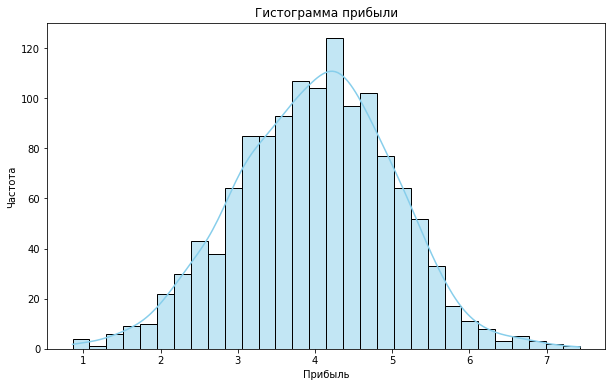

In [46]:
# Построение гистограммы с Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['Прибыль'], bins=30, kde=True, color='skyblue')  # kde=True добавляет кривую плотности
plt.title('Гистограмма прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.show()

In [47]:
merged_df.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,Прибыль
0,215348,Снизилась,премиум,да,3.4,5,121,0.00,Товары для детей,6,2,1,5,0.0,0.0,3293.1,13,14,0.98
1,215349,Снизилась,премиум,да,4.4,4,819,0.75,Товары для детей,4,4,2,5,5216.0,4472.0,4971.6,12,10,4.16
2,215350,Снизилась,стандарт,нет,4.9,3,539,0.14,Домашний текстиль,5,2,1,5,5457.5,4826.0,5058.4,8,13,3.13
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21


In [48]:
# Фильтрация данных
merged_low = merged_df[
    (merged_df['Покупательская активность'] == 'Снизилась') & (merged_df['Прибыль'] > 4.16)
]

# Вывод отфильтрованных данных
merged_low.head()

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит,предыдущий_месяц_выручка,препредыдущий_месяц_выручка,текущий_месяц_выручка,предыдущий_месяц_время,текущий_месяц_время,Прибыль
3,215351,Снизилась,стандарт,да,3.2,5,896,0.99,Товары для детей,5,0,6,4,6158.0,4793.0,6610.4,11,13,4.87
4,215352,Снизилась,стандарт,нет,5.1,3,1064,0.94,Товары для детей,3,2,3,2,5807.5,4594.0,5872.5,8,11,4.21
7,215355,Снизилась,стандарт,нет,4.7,4,284,0.17,Товары для детей,5,1,6,4,3263.0,4749.0,3772.6,12,10,5.26
8,215356,Снизилась,стандарт,да,4.2,4,192,0.14,Косметика и аксессуары,2,2,1,3,4146.5,4433.0,4566.4,6,7,4.93
9,215357,Снизилась,стандарт,да,3.9,5,154,0.00,Техника для красоты и здоровья,3,3,9,5,0.0,0.0,5986.3,12,6,4.66


In [49]:
features = merged_df[['Тип сервиса', 'Разрешить сообщать', 'Маркет_актив_6_мес', 'Маркет_актив_тек_мес', 'Длительность', 'Акционные_покупки', 'Популярная_категория', 'Средний_просмотр_категорий_за_визит', 'Неоплаченные_продукты_штук_квартал', 'Ошибка_сервиса', 'Страниц_за_визит', 'предыдущий_месяц_выручка', 'препредыдущий_месяц_выручка', 'текущий_месяц_выручка', 'предыдущий_месяц_время', 'текущий_месяц_время',  'Прибыль']]

labels = merged_df['Покупательская активность']
    
# Получение вероятностей положительного класса
probabilities = best_model.predict_proba(features)[:, 1]  # Вероятности положительного класса

# Добавление столбца с вероятностями в DataFrame
merged_df['Вероятность_покупки'] = probabilities 

# Определение порога для вероятности
threshold = 0.5  # Выберите порог, например, 0.5, или оптимизируйте его для вашей задачи

# Формирование сегмента для анализа
merged_low = merged_df[(merged_df['Вероятность_покупки'] <= threshold) & (merged_df['Прибыль'] > 4.16)]

# Вывод результата
print(merged_low)

          id Покупательская активность Тип сервиса Разрешить сообщать  \
7     215355                 Снизилась    стандарт                нет   
83    215431                 Снизилась     премиум                 да   
327   215675                 Снизилась    стандарт                 да   
328   215676                 Снизилась    стандарт                 да   
330   215678                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1284  216632           Прежний уровень    стандарт                нет   
1293  216641           Прежний уровень    стандарт                 да   
1294  216642           Прежний уровень     премиум                 да   
1295  216643           Прежний уровень    стандарт                 да   
1296  216644           Прежний уровень    стандарт                нет   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
7                    4.7                     4           28

In [50]:
# Формирование сегмента для анализа
merged_high = merged_df[(merged_df['Вероятность_покупки'] > threshold) & (merged_df['Прибыль'] > 4.16)]

# Вывод результата
print(merged_high)

          id Покупательская активность Тип сервиса Разрешить сообщать  \
3     215351                 Снизилась    стандарт                 да   
4     215352                 Снизилась    стандарт                нет   
8     215356                 Снизилась    стандарт                 да   
9     215357                 Снизилась    стандарт                 да   
11    215359                 Снизилась    стандарт                 да   
...      ...                       ...         ...                ...   
1089  216437           Прежний уровень    стандарт                нет   
1210  216558           Прежний уровень     премиум                 да   
1216  216564           Прежний уровень    стандарт                 да   
1259  216607           Прежний уровень    стандарт                 да   
1288  216636           Прежний уровень     премиум                 да   

      Маркет_актив_6_мес  Маркет_актив_тек_мес  Длительность  \
3                    3.2                     5           89

Среди пользователей с высокой прибылью больше подписаны на пакет "стандарт" чем пользователи с низкой прибылью (и меньший процент пользователей с подпиской "премиум" соответственно)

Среди пользователей с высокой покупательской активностью лидируют категории "товары для детей" и "домашний текстиль", на третьем месте: "Мелкая бытовая техника и электроника"

Среди пользователей с низкой покупательской активностью лидируют категории "товары для детей" (с большим отрывом) и "Косметика и аксессуары", на третьем месте: "Домашний текстиль"

Количество разрещений и запретов на уведомления примерно одинаковое

/tmp/ipykernel_893/4074044268.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/4074044268.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/4074044268.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/4074044268.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


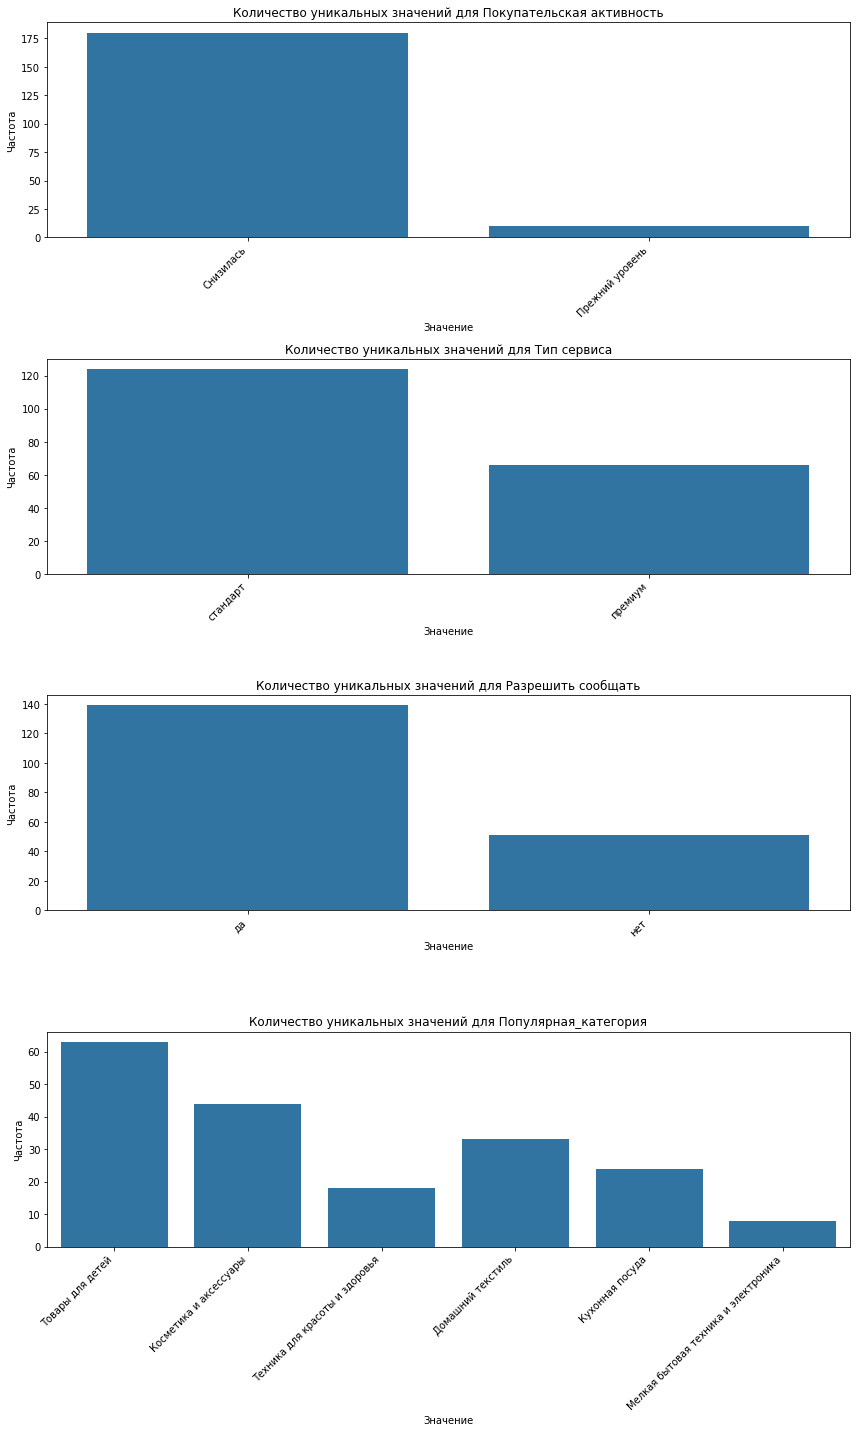

In [51]:
#строим графики sns.countplot для merged_high

# Нахождение дискретных столбцов (предполагая, что они имеют тип 'object' или 'category')
discrete_columns = merged_high.select_dtypes(include=['object', 'category']).columns

# Подготовка массива фигур и осей для графиков
fig, axes = plt.subplots(len(discrete_columns), 1, figsize=(12, len(discrete_columns) * 5))

# Построение countplot для каждого дискретного столбца
for ax, column in zip(axes, discrete_columns):
    sns.countplot(data=merged_high, x=column, ax=ax)
    ax.set_title(f'Количество уникальных значений для {column}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Подгонка и отображение графиков
plt.tight_layout()
plt.show()


/tmp/ipykernel_893/120858766.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/120858766.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/120858766.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
/tmp/ipykernel_893/120858766.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


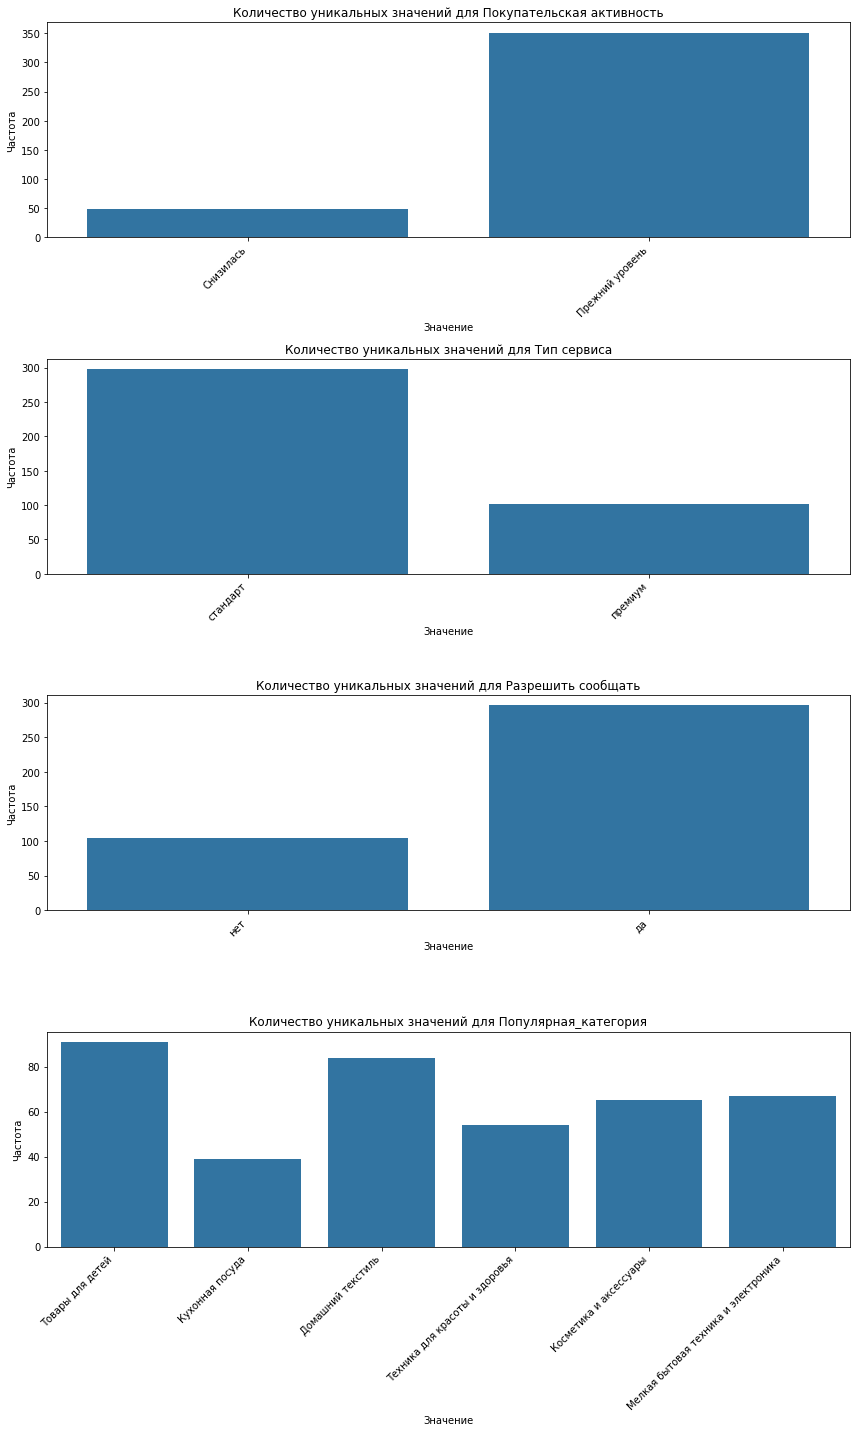

In [52]:
#строим графики sns.countplot для merged_low

# Нахождение дискретных столбцов (предполагая, что они имеют тип 'object' или 'category')
discrete_columns = merged_low.select_dtypes(include=['object', 'category']).columns

# Подготовка массива фигур и осей для графиков
fig, axes = plt.subplots(len(discrete_columns), 1, figsize=(12, len(discrete_columns) * 5))

# Построение countplot для каждого дискретного столбца
for ax, column in zip(axes, discrete_columns):
    sns.countplot(data=merged_low, x=column, ax=ax)
    ax.set_title(f'Количество уникальных значений для {column}')
    ax.set_xlabel('Значение')
    ax.set_ylabel('Частота')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Подгонка и отображение графиков
plt.tight_layout()
plt.show()


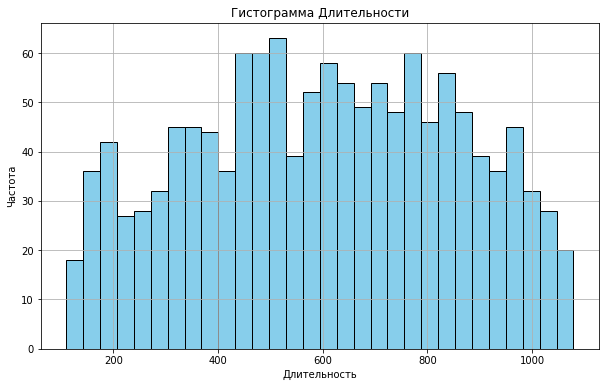

In [53]:
# Построение гистограммы
plt.figure(figsize=(10, 6))  # Опционально: настраиваем размер фигуры
plt.hist(merged_df['Длительность'], bins=30, color='skyblue', edgecolor='black')  # bins - количество столбцов в гистограмме
plt.title('Гистограмма Длительности')
plt.xlabel('Длительность')
plt.ylabel('Частота')
plt.grid(True)  # Опционально: добавление сетки на график
plt.show()

*Непрерывные признаки*

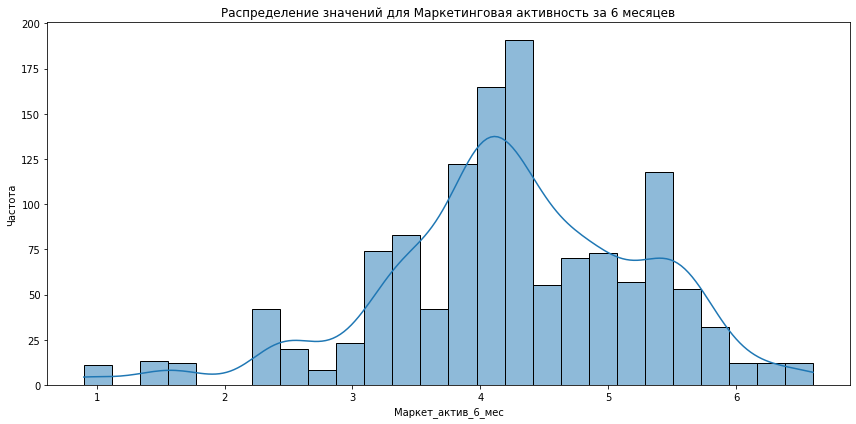

In [54]:
plt.figure(figsize=(12, 6))

# Построение гистограммы для 'Маркет_актив_6_мес'
sns.histplot(data=merged_df, x='Маркет_актив_6_мес', kde=True)

# Настройка заголовков и меток
plt.title('Распределение значений для Маркетинговая активность за 6 месяцев')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Частота')

# Показываем график
plt.tight_layout()
plt.show()

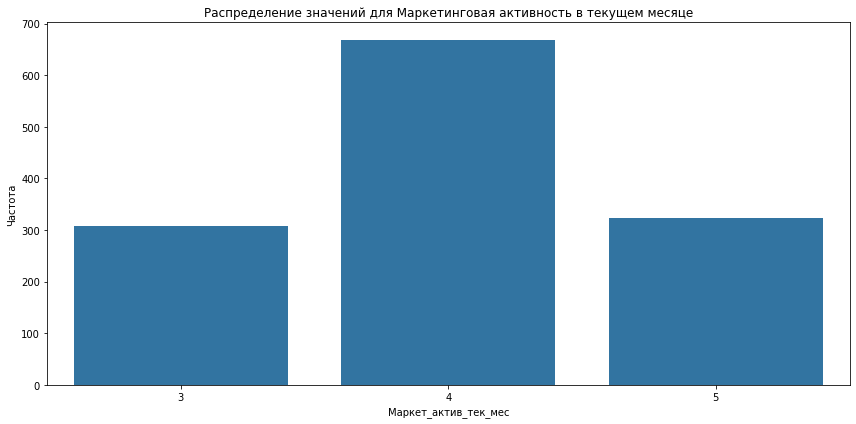

In [55]:
plt.figure(figsize=(12, 6))

# Построение гистограммы для 'Маркет_актив_6_мес'
sns.countplot(data=merged_df, x='Маркет_актив_тек_мес')

# Настройка заголовков и меток
plt.title('Распределение значений для Маркетинговая активность в текущем месяце')
plt.xlabel('Маркет_актив_тек_мес')
plt.ylabel('Частота')

# Показываем график
plt.tight_layout()
plt.show()

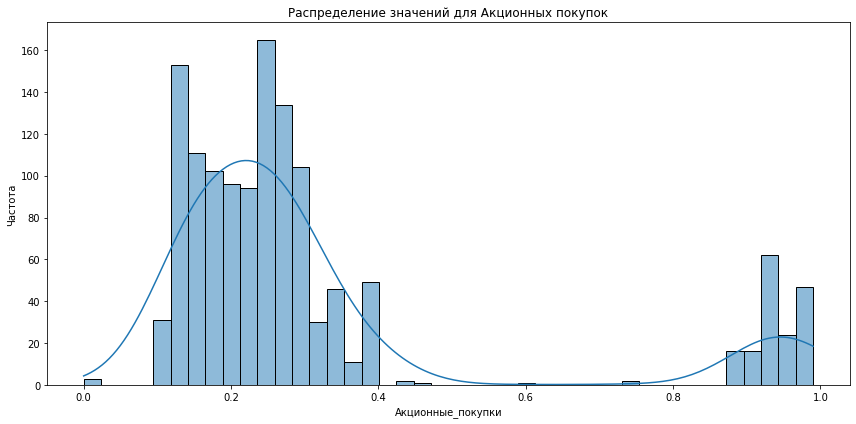

In [56]:
plt.figure(figsize=(12, 6))

# Построение гистограммы для Акционных_покупок
sns.histplot(data=merged_df, x='Акционные_покупки', kde=True)

# Настройка заголовков и меток
plt.title('Распределение значений для Акционных покупок')
plt.xlabel('Акционные_покупки')
plt.ylabel('Частота')

# Показываем график
plt.tight_layout()
plt.show()

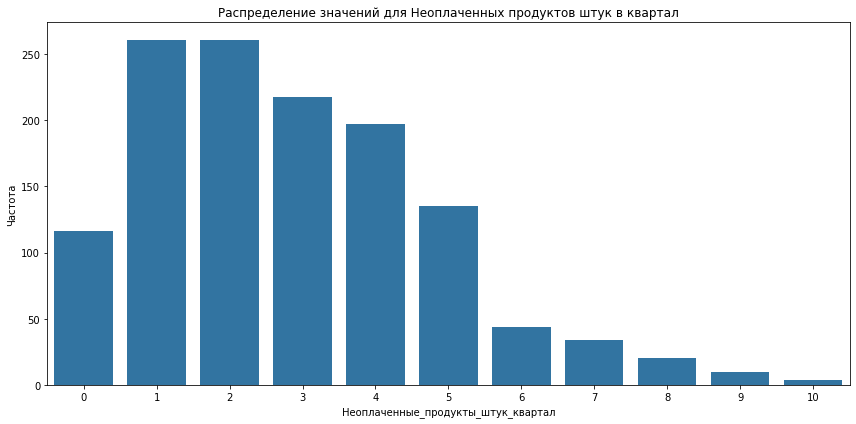

In [57]:
plt.figure(figsize=(12, 6))

# Построение гистограммы для Неоплаченных продуктов штук в квартал
sns.countplot(data=merged_df, x='Неоплаченные_продукты_штук_квартал')

# Настройка заголовков и меток
plt.title('Распределение значений для Неоплаченных продуктов штук в квартал')
plt.xlabel('Неоплаченные_продукты_штук_квартал')
plt.ylabel('Частота')

# Показываем график
plt.tight_layout()
plt.show()

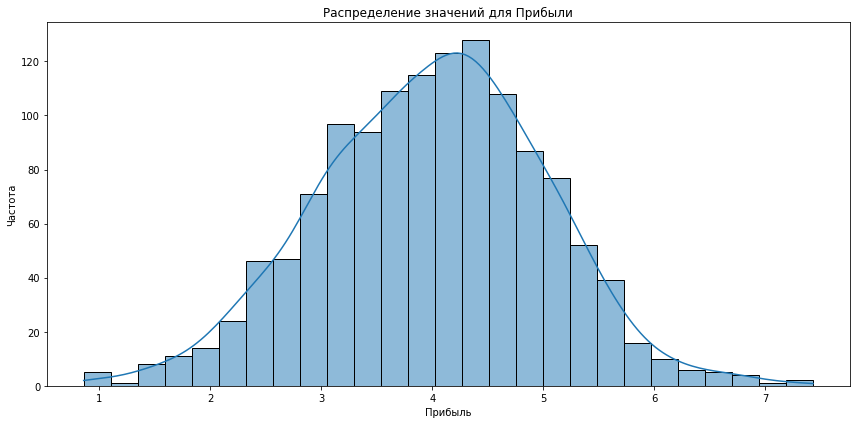

In [58]:
plt.figure(figsize=(12, 6))

# Построение гистограммы для Прибыли
sns.histplot(data=merged_df, x='Прибыль', kde=True)

# Настройка заголовков и меток
plt.title('Распределение значений для Прибыли')
plt.xlabel('Прибыль')
plt.ylabel('Частота')

# Показываем график
plt.tight_layout()
plt.show()

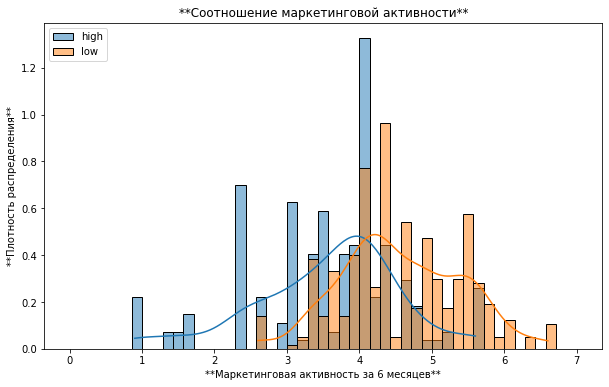

In [59]:
# Данные из датафреймов
x = merged_high['Маркет_актив_6_мес']
y = merged_low['Маркет_актив_6_мес']

# Параметры для линейного разбиения бин
bins = np.linspace(0, 7, 50)

# Построение нормированных гистограмм
plt.figure(figsize=(10, 6))
sns.histplot(x, bins=bins, alpha=0.5, kde=True, stat='density', label='high')
sns.histplot(y, bins=bins, alpha=0.5, kde=True, stat='density', label='low')

# Добавление легенды и подписей
plt.legend(loc='upper left')
plt.title('**Соотношение маркетинговой активности**')
plt.xlabel('**Маркетинговая активность за 6 месяцев**')
plt.ylabel('**Плотность распределения**')
plt.show()


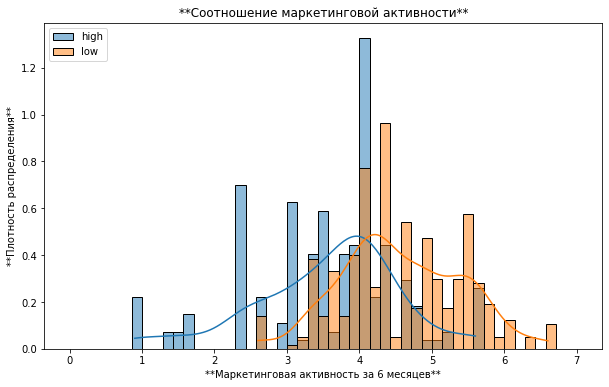

In [60]:
# Данные из датафреймов
x = merged_high['Маркет_актив_6_мес']
y = merged_low['Маркет_актив_6_мес']

# Параметры для линейного разбиения бинов
bins = np.linspace(0, 7, 50)

# Построение нормированных гистограмм
plt.figure(figsize=(10, 6))
sns.histplot(x, bins=bins, alpha=0.5, kde=True, stat='density', label='high', common_norm=False)
sns.histplot(y, bins=bins, alpha=0.5, kde=True, stat='density', label='low', common_norm=False)

# Добавление легенды и подписей
plt.legend(loc='upper left')
plt.title('**Соотношение маркетинговой активности**')
plt.xlabel('**Маркетинговая активность за 6 месяцев**')
plt.ylabel('**Плотность распределения**')

# Показываем график
plt.show()

Маркетинговая активность среди пользователей, которые приносят большую прибыль в целом выше. Среди пользователей с низкой прибылью мы видим рост активности до значения 4.3 и затем последующее падение

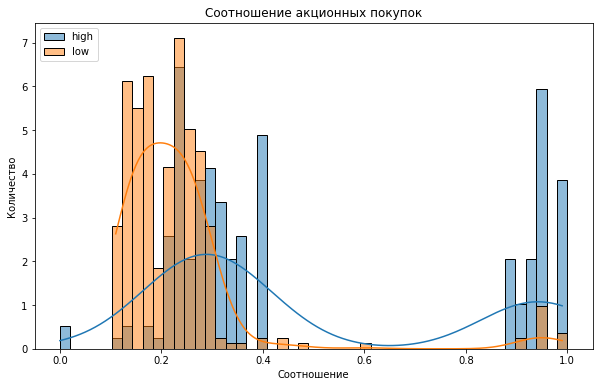

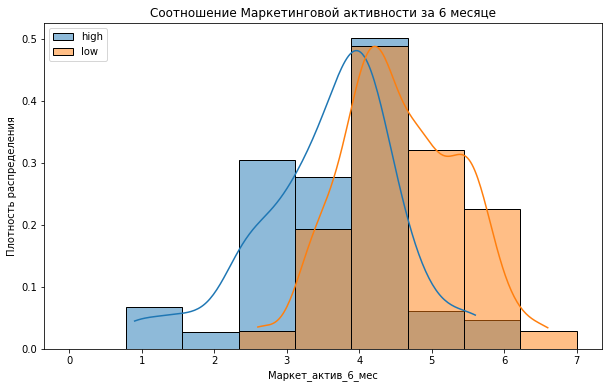

In [61]:
# Данные из датафрейма merged_high
x = merged_high['Акционные_покупки']

# Данные из датафрейма merged_low
y = merged_low['Акционные_покупки']

bins = np.linspace(0, 1)

plt.figure(figsize=(10, 6))
sns.histplot(x, bins=bins, alpha=0.5, kde=True, stat='density', label='high', common_norm=False)
sns.histplot(y, bins=bins, alpha=0.5, kde=True, stat='density', label='low', common_norm=False)

plt.legend(loc='upper left')
plt.title('Соотношение акционных покупок')
plt.xlabel('Соотношение')
plt.ylabel('Количество')

plt.show()

# Данные из датафреймов
x = merged_high['Маркет_актив_6_мес']
y = merged_low['Маркет_актив_6_мес']

# Параметры для линейного разбиения бинов
bins = np.linspace(0, 7, 10)

# Построение нормированных гистограмм
plt.figure(figsize=(10, 6))
sns.histplot(x, bins=bins, alpha=0.5, kde=True, stat='density', label='high', common_norm=False)
sns.histplot(y, bins=bins, alpha=0.5, kde=True, stat='density', label='low', common_norm=False)

# Добавление легенды и подписей
plt.legend(loc='upper left')
plt.title('Соотношение Маркетинговой активности за 6 месяце')
plt.xlabel('Маркет_актив_6_мес')
plt.ylabel('Плотность распределения')

# Показываем график
plt.show()

У обеих групп пользователей мы видим две категории акционных покупок - "0.05 - 0.4" и "0.9 - 1.0". Пользователи с покупательской активностью  покупают в первом диапазоне гораздо больше, чем во втором. Пользователи с низкой покупательской активностью покупают в обоих диапазонах одинаково 

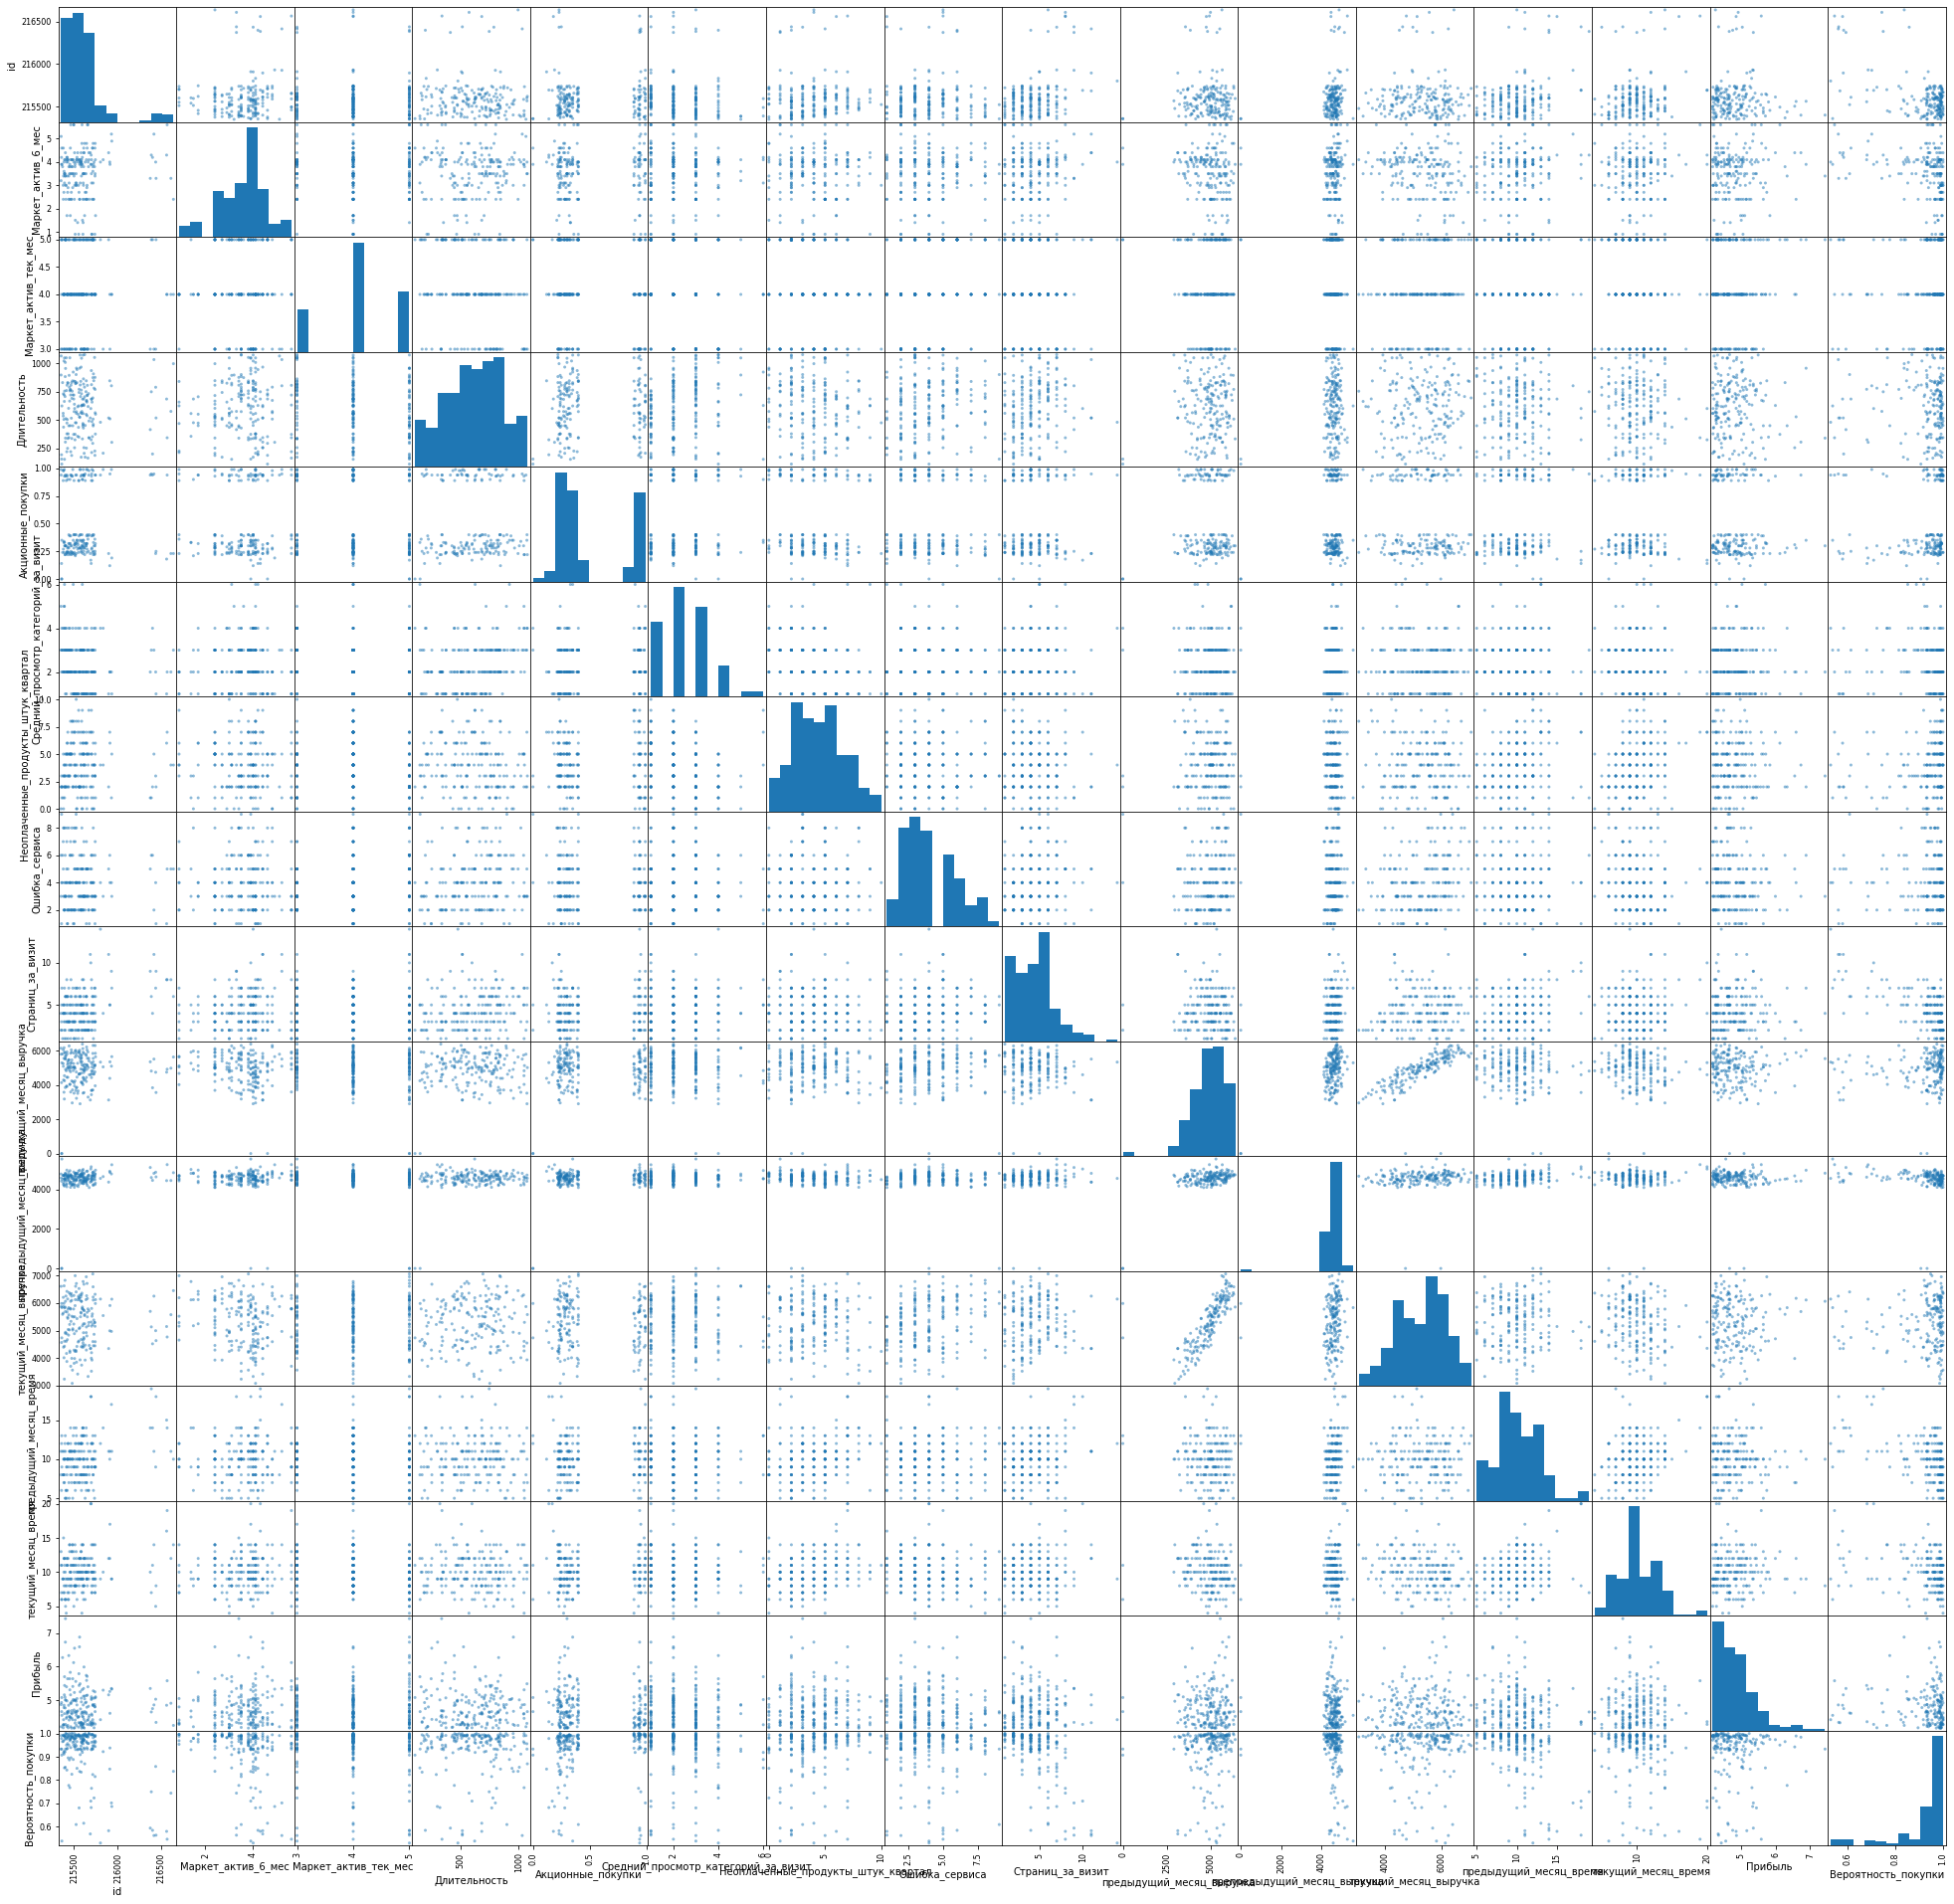

In [62]:
#все диаграммы рассеяния на одном графике
pd.plotting.scatter_matrix(merged_high, figsize=(34,34))
plt.show()

In [ ]:
#все диаграммы рассеяния на одном графике
pd.plotting.scatter_matrix(merged_low, figsize=(24,24))
plt.show()

У пользователей с низкой покупательской активностью другое поведение при акционных покупках - есть две категории: 

1. среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет "0.05 - 0.4" 

2. среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев составляет "0.9 - 1.0"

в то время как у пользователей с высокой покупательской активностью выделяется только первая категория. Т.о. можно предположить, что пользователи с низкой покупательской активностью ждут акции и предпочитают покупать товары только по акциям. Если акции на данный товар нет, то они его покупать не будут. 

Выход из данной ситуации - продумать акционную политику при которой нужно покупать несколько товаров. Или увеличить показ акционных товаров из менее интересных для данного сегмента пользователей категорий

***Шаг 9. Общий вывод***

***Было поставлено две задачи:***

1.Построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2.Выделить сегменты покупателей и разработать для них персонализированные предложения.

- Были предоставлены 4 таблицы с данными:

market_file.csv
Таблица, которая содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и его продуктовом поведении.

market_money.csv
Таблица с данными о выручке, которую получает магазин с покупателя, то есть сколько покупатель всего потратил за период взаимодействия с сайтом.

market_time.csv
Таблица с данными о времени (в минутах), которое покупатель провёл на сайте в течение периода

money.csv
Таблица с данными о среднемесячной прибыли покупателя за последние 3 месяца: какую прибыль получает магазин от продаж каждому покупателю

В результате предобработки данных мы исправили опечатки, удалили дубликаты и пропуски 

- Для поиска лучшей модели мы объединили все данные в одну таблицу, затем провели масштабирование и категоризацию данных 

В результате лучшей моделью оказалась модель:
LogisticRegression(C=1, penalty='l1', random_state=42, solver='liblinear'))])
С метрикой на тренировочной выборке: 0.9015256297619934
И метрикой ROC-AUC на тестовой выборке: 0.8355

- Затем был проведен анализ сегмента покупателей с низкой покупательской активностью и высокой прибыльностью. В ходе исследования было предложено немного изменить акционную политику, т.к. пользователи в меньшей степени покупают товары без акций. Также возможно стимулировать приобретение второго товара по акции при покупке первого без акции 